In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import vonmises
from gstools import SRF, Spherical
from gstools import SRF, Gaussian
from gstools import SRF, Exponential
from scipy.optimize import curve_fit
from scipy.stats import norm

In [160]:
def media_circular(theta):
    cos_bar=np.mean(np.cos(theta))
    sin_bar=np.mean(np.sin(theta))
    
    return(np.arctan2(sin_bar,cos_bar))
def circmedian(angs):
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + np.pi) % (2 * np.pi) - np.pi
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]


crcMedian=np.vectorize(circmedian)


def dist_circular(theta1,theta2):
    return(np.pi-abs(np.pi-abs(theta1-theta2)))
def cGaussian(d,n,rho,r):
    return(rho**2+(1-n-rho**2)*np.exp(-3*d/r))
def cExponential(d,n,rho,r):
    return(rho**2+(1-n-rho**2)*np.exp(-3*(d/r)**2))
def cSpherical(d,n,rho,r):
    t=[]
    for i in range(len(d)):
        if(d[i]<=r):
            t.append(1-n-(1-n-rho**2)*(3/2*(d[i]/r)-1/2*(d[i]/r)**3))
        else:
            t.append(rho**2)

    return(np.array(t))

def cSphericalt(d,n,rho,r):
    t=[]
    if(d<=r):
        t.append(1-n-(1-n-rho**2)*(3/2*(d/r)-1/2*(d/r)**3))
    else:
        t.append(rho**2)

    return(np.array(t))

def cosiengram(epsilon,data,X_b,Y_b):
    dx=max(X_b)-min(X_b)
    dy=max(Y_b)-min(Y_b)
    n=len(data)
    cosiengram=[]
    
    distances=np.linspace(epsilon,np.sqrt(dy**2+dx**2),len(data))
    for d in distances:
        cosines=[]
        for i in range(n):
            cx,cy=(X_b[i],Y_b[i])
            target = np.sqrt((X_b - cx)**2 + (Y_b - cy)**2)
            cosines.append(np.mean(np.cos(data[i]-data[target<=d])))
        cosiengram.append(np.mean(cosines))
    return(cosiengram,distances)

def K(p,func,X,Y):
    K=np.identity(len(X))
    for i in range(1,len(X)):
        for j in range(i,len(X)):
            K[i,j]=func(np.sqrt((X[i]-X[j])**2+(Y[i]-Y[j])**2),p[0],p[1],p[2])
            K[j,i]=K[i,j]
    
    return(K)
        
    
def C(p,func,x,y,X,Y):
    c=[]
    for i in range(len(X)):
        c.append(func(np.sqrt((X[i]-x)**2+(Y[i]-y)**2),p[0],p[1],p[2]))
    return(c)

def RandomFieldVonMises(rho,x_0,y_0,x_n,y_n,nx,ny):
    x=np.linspace(x_0,x_n,nx)
    y = np.linspace(y_0,y_n,ny)
    model = Spherical(dim=2, var=1, len_scale=10)
    srf = SRF(model)
    field = srf.structured([x, y])
    f=vonmises.ppf(norm.cdf((field-np.mean(field))/np.std(field)),rho)
    X,Y = np.meshgrid(np.linspace(x_0,x_n,nx),np.linspace(y_0,y_n,ny))
    X=np.reshape(X,(-1,nx*ny))[0]
    Y=np.reshape(Y,(-1,nx*ny))[0]
    f=np.reshape(f,(-1,nx*ny))[0]
    return(X,Y,f)

def krigCirc(x_new,y_new,p,func,Xk,Yk,Datak):
    n_new=len(x_new)
    cosine=[]
    sine=[]
    h_d=np.cos(Datak)
    v_d=np.sin(Datak)
    K_inverse=np.linalg.inv(K(p,func,Xk,Yk))
    for i in range(n_new):
        K_1c=np.matmul(K_inverse,C(p,func,x_new[i],y_new[i],Xk,Yk))
        cosine.append(np.matmul(h_d,K_1c))
        sine.append(np.matmul(v_d,K_1c))
    return(np.array(cosine),np.array(sine))

In [140]:
X,Y,f=RandomFieldVonMises(1.1,0,0,12,12,11,11)

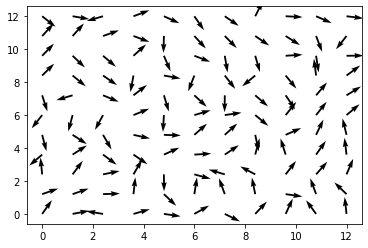

In [141]:
plt.quiver(X,Y,np.cos(f),np.sin(f))
plt.show()

In [142]:
trend=np.array([157, 141, 126, 113, 101, 90, 79, 67, 54, 40, 25, 152, 137, 123, 111, 100, 90, 80, 69, 57, 44, 30,
 147, 133, 120, 109, 99, 90, 81, 71, 60, 48, 35, 142, 129, 117, 107, 98, 90, 82, 73, 63, 52, 40,
 137, 125, 114, 105, 97, 90, 83, 75, 66, 56, 45, 132, 121, 111, 103, 96, 90, 84, 77, 69, 60, 50,
 127, 117, 108, 101, 95, 90, 85, 79, 72, 64, 55, 122, 113, 105, 99, 94, 90, 86, 81, 75, 68, 60,
 117, 109, 102, 97, 93, 90, 87, 83, 78, 72, 65, 112, 105, 99, 95, 92, 90, 88, 85, 81, 76, 70,
 107, 101, 96, 93, 91, 90, 89, 87, 84, 80, 75])*np.pi/180

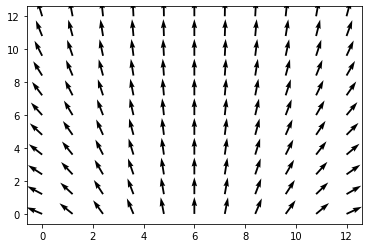

In [143]:
plt.quiver(X,Y,np.cos(trend),np.sin(trend))
plt.show()

In [144]:
Data=trend+f

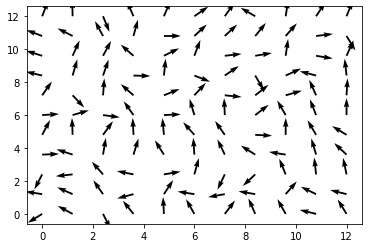

In [145]:
plt.quiver(X,Y,np.cos(Data),np.sin(Data))
plt.show()

In [153]:
c,d=cosiengram(0.05,Data,X,Y)

In [154]:
poptG, pcov=curve_fit(cGaussian,d,c)
poptE, pcov=curve_fit(cExponential,d,c)
poptS, pcov=curve_fit(cSpherical,d,c)


C:\Users\57314\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


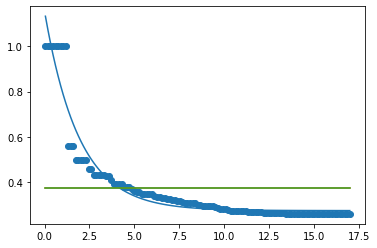

In [155]:
plt.plot(d,cGaussian(d,poptG[0],poptG[1],poptG[2]))
plt.plot(d,cExponential(d,poptE[0],poptE[1],poptE[2]))
plt.plot(d,cSpherical(d,poptS[0],poptS[1],poptS[2]))
plt.scatter(d,c)

def krigCircPropuesta(x_new,y_new,p,func,Xk,Yk,Datak):
    n_new=len(x_new)
    cosine=[]
    sine=[]
    h_d=np.cos(Datak)
    v_d=np.sin(Datak)
    K_inverse=np.linalg.inv(K(p,func,Xk,Yk))
    
    ones_n=np.ones(len(Xk))
    
    for i in range(n_new):
        c=np.array(C(p,func,x_new[i],y_new[i],Xk,Yk))
        K_1c=K_inverse@c-((K_inverse@ones_n)*(c.T@(K_inverse@ones_n))-K_inverse@ones_n)/len(Xk)
        cosine.append(np.matmul(h_d,K_1c))
        sine.append(np.matmul(v_d,K_1c))
    return(np.array(cosine),np.array(sine))
        

In [161]:
X_new,Y_new = np.meshgrid(np.linspace(0,12,30),np.linspace(0,12,30))
X_new=np.reshape(X_new,(-1,900))[0]
Y_new=np.reshape(Y_new,(-1,900))[0]

In [162]:
h,v=krigCirc(X_new,Y_new,poptG,cGaussian,X,Y,Data)

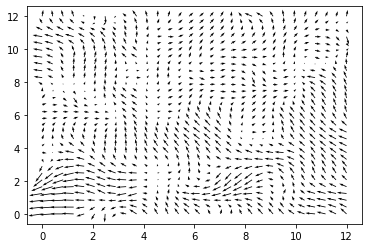

In [163]:
plt.quiver(X_new,Y_new,h,v)
plt.show()

In [95]:
def medianPolishCirc(datos):
    nx=datos.shape[0]
    ny=datos.shape[1]
    
    dat=np.zeros([nx+1,ny+1])
    dat[:-1,:-1]=datos
    
    temp=np.zeros([nx+1,ny+1])
    while (abs(dat-temp)>=1e-5).any():
    
        temp=dat
        for i in range(nx): 
            dat[i,-1]=temp[i,-1]+circmedian(temp[i,:-1])
            dat[i,:-1]=temp[i,:-1]-circmedian(temp[i,:-1])
        
        temp=dat
        
        for j in range(ny):
            column=temp[:-1,j]
            dat[-1,j]=temp[-1,j]+circmedian(column)
            dat[:-1,j]=column-circmedian(column)
        
        temp=dat
        
    return(dat)
        

    

In [93]:
def medianPolish(datos):
    nx=datos.shape[0]
    ny=datos.shape[1]
    
    dat=np.zeros([nx+1,ny+1])
    dat[:-1,:-1]=datos
    
    for i in range(nx): 
        dat[i,-1]=dat[i,-1]+np.median(dat[i,:-1])
        dat[i,:-1]=dat[i,:-1]-np.median(dat[i,:-1])
        
        
    for j in range(ny):
        column=dat[:-1,j]
        dat[-1,j]=dat[-1,j]+np.median(column)
        dat[:-1,j]=column-np.median(column)
    return(dat)

In [126]:
Mp=medianPolishCirc(Data.reshape(11,11))

In [128]:
Mp[-1,:]

array([ 0.33771683,  0.39431228,  0.50291797,  0.38899929, -0.0617994 ,
       -0.5267223 , -0.91895551, -0.18414981,  0.        ,  0.        ,
       -0.57452935,  0.        ])

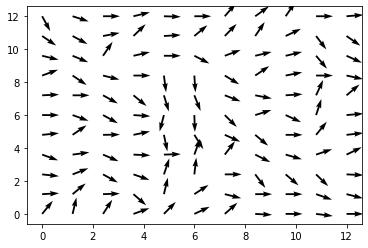

In [98]:
plt.quiver(X,Y,np.cos(Mp),np.sin(Mp))
plt.show()

In [99]:
MpC=medianPolish(np.cos(Data).reshape(11,11))[:-1,:-1].reshape(121,)
MpS=medianPolish(np.sin(Data).reshape(11,11))[:-1,:-1].reshape(121,)


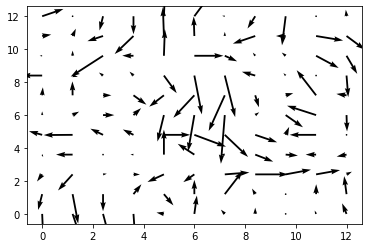

In [108]:
plt.quiver(X,Y,MpC,MpS)
plt.show()

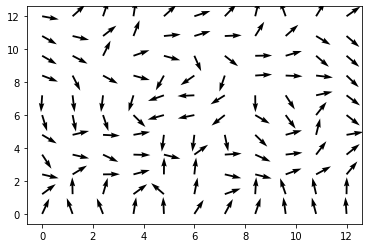

In [109]:
plt.quiver(X,Y,np.cos(f),np.sin(f))
plt.show()

In [115]:
theta_mp=np.arctan2(MpC,MpS)

In [116]:
np.mean(np.abs(np.cos(f)-np.cos(Mp)))

0.4963471464958533

In [124]:
np.mean(abs(np.cos(f-Mp)))

0.6431170476206104

In [121]:
np.mean(np.abs(np.cos(f)-np.cos(theta_mp)))

0.6527327238764689

In [123]:
np.mean(abs(np.cos(f-theta_mp)))

0.6236965610120616